# Задание: написать простую двухслойную нейросеть на numpy

In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

0it [00:00, ?it/s]

9920512it [00:02, 4022252.13it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 79586.13it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:03, 494590.33it/s]                             
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


8192it [00:00, 18305.37it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


## Переводим его в два класса

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

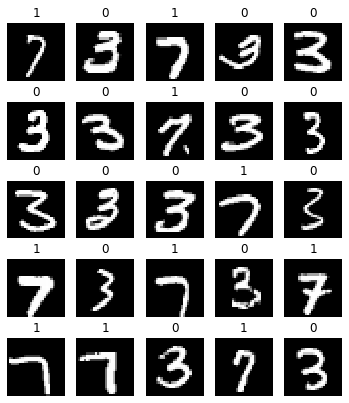

In [6]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### классу 0 соответствует цифра 3
### классу 1 соответствует цифра 7

# поучим пока не очень красиво нашу 2-х слойную нейронку

In [7]:
def bce(y_true, y_proba, batch_size):    
    return - np.sum((y_true * np.log(y_proba) + (1 - y_true) * np.log(1 - y_proba))) / batch_size

In [8]:
learning_rate = 0.01
epochs = 10

w1 = np.random.rand(784, 256) * 0.01
b1 = np.zeros(256)
w2 = np.random.rand(256, 1) * 0.01
b2 = np.zeros(1)

losses = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    epoch_losses = []
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)
        
        # forward
        z1 = np.dot(x, w1) + b1
        a1 = 1 / (1 + np.exp(-z1))        
        z2 = np.dot(a1, w2) + b2
        pred = 1 / (1 + np.exp(-z2))
        
        # расчет bce
        epoch_losses.append(bce(y, pred, 128))
        
        # backward
        d_loss_d_pred = - (y * (1 / pred) + (1 - y) * (- (1 / (1 - pred))))
        d_pred_d_z2 = (1 / (1 + np.exp(-z2))) * (1 - 1 / (1 + np.exp(-z2))) * d_loss_d_pred
        d_z2_d_a1 = np.dot(d_pred_d_z2, w2.T)
        d_z2_d_w2 = np.dot(a1.T, d_pred_d_z2)
        d_z2_d_b2 = np.sum(d_pred_d_z2, axis=0)
        d_a1_d_z1 = (1 / (1 + np.exp(-z1))) * (1 - 1 / (1 + np.exp(-z1))) * d_z2_d_a1
        d_z1_d_w1 = np.dot(x.T, d_a1_d_z1)
        d_z1_d_b1 = np.sum(d_a1_d_z1, axis=0)                                                         
        
        # gradient descent
        
        w2 = w2 - learning_rate * d_z2_d_w2
        b2 = b2 - learning_rate * d_z2_d_b2
        w1 = w1 - learning_rate * d_z1_d_w1
        b1 = b1 - learning_rate * d_z1_d_b1
        
    losses.append(np.mean(epoch_losses))
    
    print(f'loss: {np.mean(epoch_losses)}')
        
        

Epoch: 1
loss: 0.33213188492488693
Epoch: 2
loss: 0.04829730635030577
Epoch: 3
loss: 0.03409769129794581
Epoch: 4
loss: 0.027667046915879435
Epoch: 5
loss: 0.022220939797490763
Epoch: 6
loss: 0.018744293133827174
Epoch: 7
loss: 0.015111978347060554
Epoch: 8
loss: 0.012755772725834306
Epoch: 9
loss: 0.011121934128602958
Epoch: 10
loss: 0.009847097166810476


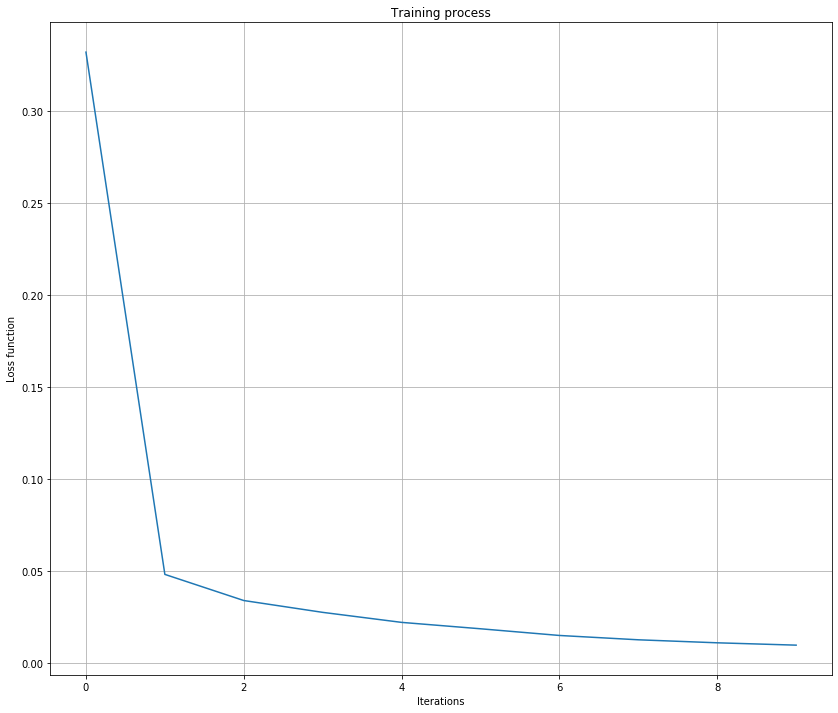

In [9]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# по-крутому

In [10]:
class Sigmoid:

    def __init__(self):

        self._sigmoid_result = None

    def forward(self, x):

        self._sigmoid_result = 1 / (1 + np.exp(-x))

        return self._sigmoid_result

    def backward(self, grad):
        
        new_grad = self._sigmoid_result * (1 - self._sigmoid_result) * grad

        return new_grad

    def step(self, learning_step):

        pass

In [11]:
class ReLU:

    def __init__(self):
        
        self._RelU_result = None

    def forward(self, x):

        self._RelU_result = np.maximum(0, x)
        
        return self._RelU_result

    def backward(self, grad):
        
        relu_grad = self._RelU_result > 0
        new_grad = grad * relu_grad
        
        return new_grad

    def step(self, learning_rate):

        pass

In [12]:
class Linear:

    def __init__(self, in_features, out_features):
        # инициализируем веса
        self.weight = np.random.rand(in_features, out_features) * 0.01
        self.bias = np.zeros(out_features)
        
        # сохраняем градиент для весов
        self._grad_weight = None
        self._grad_bias = None

    def forward(self, x):
        self.x = x
        return np.dot(x, self.weight) + self.bias

    def backward(self, grad):
        self._grad_weight = np.dot(self.x.T, grad)
        self._grad_bias = np.sum(grad, axis=0)
        return np.dot(grad, self.weight.T)

    def step(self, learning_rate):
        self.weight -= learning_rate * self._grad_weight
        self.bias -= learning_rate * self._grad_bias

In [13]:
class BCELoss:

    def __init__(self):
        
        pass

    def forward(self, x, y):

        y = np.expand_dims(y, 1)
        self.x = x
        self.y = y
        
        return - np.sum((self.y * np.log(self.x) + (1 - self.y) * np.log(1 - self.x))) / self.x.shape[0]

    def backward(self):
        return - (self.y * (1 / self.x) + (1 - self.y) * (- (1 / (1 - self.x)))) / self.x.shape[0]
    
    def step(self, learning_rate):
        pass

# Реализуйте обёртку над слоями - нейронную сеть

In [14]:
class NeuralNetwork:

    def __init__(self, modules):

        # список слоев
        self.modules = modules

    def forward(self, x):
        
        for layer in self.modules:
            x = layer.forward(x)
        return x
            
    def backward(self, grad):
        """
        :grad: градиент от функции потерь
        :return: возвращать ничего не потребуется
        """
        for layer in self.modules[::-1]:
            grad = layer.backward(grad)
            
            
    def step(self, learning_rate):    
        for layer in self.modules[::-1]:
            layer.step(learning_rate)

## Реализуйте обертку над моделью

In [15]:
from our_library import wrapper

In [16]:
class MNISTWrapper(wrapper.Wrapper):

    def __init__(self, model, loss, learning_rate=0.001, multi_class=False):

        # передаем параметры, чтобы отработал __init__ от наследуемого класса
        # можно было бы сделать через **kwargs, но сделал так для наглядности и чтобы были подсказки в юпитере

        super().__init__(model=model, loss=loss, learning_rate=learning_rate, multi_class=multi_class)

    def train_batch(self, x, y):
        
        prediction = self.model.forward(x)
        loss_batch = self.loss.forward(prediction, y)
        grad = self.loss.backward()
        self.model.backward(grad)
        self.model.step(self.learning_rate)
        
        return loss_batch, prediction

    def predict_batch(self, x):        
        return self.model.forward(x)

In [17]:
# задайте гиперпараметры
learning_rate = 0.01
epochs = 5

# задайте слои в свою нейронную сеть, например, 3 слоя
neural_network = NeuralNetwork([Linear(784, 256), ReLU(), Linear(256, 1), Sigmoid()])

loss = BCELoss()

In [18]:
classifier = MNISTWrapper(model=neural_network,
                          loss=loss,
                          learning_rate=learning_rate)

In [19]:
classifier.train(train_loader, test_loader, epochs=epochs)

Epoch 5: 100%|██████████| 12396/12396 [00:04<00:00, 3091.48it/s, loss=0.0774, metric=0.978]
